# Метод опорных векторов (SVM)

Реализация машины опорных векторов на основе статьи ["SVM. Подробный разбор метода опорных векторов, реализация на python"](https://habr.com/ru/company/ods/blog/484148/).

In [1]:
# Модули, настройка, функции

import numpy as np
np.random.seed(seed=2)
import pandas as pd
import matplotlib.animation as animation
from matplotlib import pyplot as plt, cm
from matplotlib.patches import Arrow
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from IPython import display

# Отступ и функции потерь

# Отступ для y ∈ {-1, 1}
def margin(a, y):
  '''Отступ для y ∈ {-1, 1}'''
  return a * y

# Отступ для y ∈ {0, 1}
def margin_01(a, y):
  '''Отступ для y ∈ {0, 1}'''
  return a * (2 * y - 1)

# Пороговая фукнция потерь
def threshold_loss(m):
  '''Пороговая фукнция потерь для отступа m'''
  return m < 0

# Hinge Loss
def hinge_loss(m):
  '''Кусочно-линейная фукнция потерь Hinge Loss для отступа m'''
  return np.maximum(0, 1 - m)

# Векторизация фнукций
margin = np.vectorize(margin)
threshold_loss = np.vectorize(threshold_loss)
hinge_loss = np.vectorize(hinge_loss)

# Генерация и разметка данных
def generate_data(mu_neg=(0, 0), sigma_neg=1, size_neg=1, mu_pos=(0, 0), sigma_pos=1, size_pos=1):
  '''
  Генерация матрицы признаков X типа pandas.DataFrame и вектора целевого
  признака y типа pandas.Series.

  Входные параметры:
    mu_neg    - математическое ожидание объектов класса -1;
    sigma_neg - стандартное отклонение объектов класса -1;
    size_neg  - количество объектов класса -1; 
    mu_pos    - математическое ожидание объектов класса +1;
    sigma_pos - стандартное отклонение объектов класса +1;
    size_pos  - количество объектов класса +1
  '''
  x0 = [1] * (size_neg + size_pos) # Фиктивный признак
  x1 = np.hstack((mu_neg[0] + sigma_neg * np.random.randn(size_neg), mu_pos[0] + sigma_pos * np.random.randn(size_pos)))
  x2 = np.hstack((mu_neg[1] + sigma_neg * np.random.randn(size_neg), mu_pos[1] + sigma_pos * np.random.randn(size_pos)))
  y = np.hstack((-np.ones(size_neg), np.ones(size_pos)))
  X = pd.DataFrame(np.column_stack((x0, x1, x2, y)), columns=['x0', 'x1', 'x2', 'y'])
  X = X.sort_values(by='x1').reset_index(drop=True)
  y = X.y#.to_numpy()
  del X['y']
  return X, y

def separate_linearly(fuatures, coefficients, clear_distance=0):
  '''
  Разметка данных с помощью гиперплоскости. Объектам с отрицательной дистанцией
  до разделяющей гиперплоскости присваивается класс -1, с положительной - +1.
  Объекты на расстоянии от гиперплоскости меньше d удаляются.

  Входные параметры:
    X - матрица признаков;
    w - коэффициенты гиперплоскости вида [w0, w1, w2], где w0 - свободный член;
    d - расстояние от гиперплоскости, в пределах которого удаляются объекты
  '''
  # Вычислим для каждого дистанцию до гиперплоскости d
  fuatures['d'] = fuatures @ coefficients / np.linalg.norm(coefficients[1:])
  # Удаление объектов внутри полосы
  fuatures = fuatures.drop(X[abs(fuatures.d) <= clear_distance].index)
  fuatures = fuatures.reset_index(drop=True)
  # Новые значений целевого признака
  target = np.sign(fuatures.d).astype(int)#.to_numpy()
  del fuatures['d']
  return fuatures, target

# Графики и оси
def get_shiny_square_axes(axes, axes_arrows=True, axes_labels=('x1', 'x2'), xlim=(-1, 1), ylim=(-1, 1), hw=0.1, lw=1):
  '''Общая настройка осей 2d графиков'''
  if axes_arrows:
    axes.arrow(xlim[0], 0, xlim[1] - xlim[0], 0, length_includes_head=True, head_width=hw, lw=lw, color='r')
    axes.arrow(0, ylim[0], 0, ylim[1] - ylim[0], length_includes_head=True, head_width=hw, lw=lw, color='g')
  axes.grid(True)
  axes.set_aspect(aspect=1) # adjustable='datalim'
  axes.set_axisbelow(True)
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  axes.set_xlabel(axes_labels[0])
  axes.set_ylabel(axes_labels[1])

def get_shiny_cubic_axes(axes, axes_arrows=True, axes_labels=('x1', 'x2', 'y'), xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), alr=0.02, lw=1):
  '''Общая настройка осей 3d графиков'''
  if axes_arrows:
    axes.quiver(xlim[0], 0, 0, xlim[1] - xlim[0], 0, 0, arrow_length_ratio=alr, normalize=False, linewidth=lw, color='r')
    axes.quiver(0, ylim[0], 0, 0, ylim[1] - ylim[0], 0, arrow_length_ratio=alr, normalize=False, linewidth=lw, color='g')
    axes.quiver(0, 0, zlim[0], 0, 0, zlim[1] - zlim[0], arrow_length_ratio=alr, normalize=False, linewidth=lw, color='b')
  axes.grid(True)
  axes.set_axisbelow(True)
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  axes.set_zlim(zlim)
  axes.set_xlabel(axes_labels[0])
  axes.set_ylabel(axes_labels[1])
  axes.set_zlabel(axes_labels[2])

class MyShinySVM():

  '''Метод опорных векторов для меток класса {-1, 1}'''

  def __init__(self, eta0=0.01, alpha=0.1, epochs=1, verbose=False):

    self.eta0 = eta0
    self.alpha = alpha
    self.epochs = epochs
    self.verbose = verbose
    self.w = None
    self.w_step_history = None # Список значений коэффициентов на каждом шаге
    self.train_error_epoch_history = None # Список 
    self.train_loss_epoch_history = None #
    self.val_error_epoch_history = None #
    self.val_loss_epoch_history = None #

  def fit(self, X_train, y_train, X_val, y_val, verbose=False):
    
    self.w = np.zeros(X.shape[1])
    self.w_step_history = [self.w.tolist()] # tolist(), чтобы история хранила не ссылки, а копии, иначе все значения будут одинаковы
    self.train_error_epoch_history = []
    self.train_loss_epoch_history = []
    self.val_error_epoch_history = []
    self.val_loss_epoch_history = []

    # По всем эпохам
    for epoch in range(self.epochs):
      # Количество ошибок классификации и эмпирический риск для тренировочной выборки
      train_epoch_errors = 0
      train_epoch_loss = 0
      # Количество ошибок классификации и эмпирический риск для валидационной выборки
      val_epoch_error = 0
      val_epoch_loss = 0

      # По всем объектам тренировочной выборки
      for i in range(X_train.shape[0]):
        # Отступ
        m = self.margin(X_train[i], y_train[i])
        # Объект классифицирован верно
        if m >= 1:
          self.w -= self.eta0 * self.alpha * self.w / self.epochs
        # Объект классифицирован неверно (m <= 0) или попадает на полосу разделения (0 < m < 1)
        else:
          self.w -= -self.eta0 * (y_train[i] * X_train[i] - self.alpha * self.w / self.epochs)
        train_epoch_errors += int(m < 1)
        train_epoch_loss += self.soft_margin_loss(m)
        self.w_step_history.append(self.w.tolist())

      # По всем объектам валидационной выборки
      for i, x in enumerate(X_val):
        m = self.margin(X_val[i], y_val[i])
        val_epoch_error += int(m < 1)
        val_epoch_loss += self.soft_margin_loss(m)

      # Информация о схождении после каждой эпохи
      if self.verbose:
        print('Эпоха: {:<6}   Свободный член: {:<7}   Коэффициенты: {:<15}   Soft margin loss on train data: {:<.4f}   Soft margin loss on validation data: {:<.4f}'.\
          format(epoch, str(self.w[0].round(4)), str(self.w[1:].round(4)), round(train_epoch_loss, 4), round(val_epoch_loss, 4)))

      self.train_error_epoch_history.append(train_epoch_errors)
      self.train_loss_epoch_history.append(train_epoch_loss)
      self.val_error_epoch_history.append(val_epoch_error)
      self.val_loss_epoch_history.append(val_epoch_loss)

    # Чтобы все поля были типа numpy.ndarray
    # self.w_step_history = np.array(self.w_step_history)    
    self.train_error_epoch_history = np.array(self.train_error_epoch_history)
    self.train_loss_epoch_history = np.array(self.train_loss_epoch_history)
    self.val_error_epoch_history = np.array(self.val_error_epoch_history)
    self.val_loss_epoch_history = np.array(self.val_loss_epoch_history)   

  def predict(self, X):
    '''Предсказание для объекта или матрицы объектов'''
    return np.sign(X @ self.w)  

  def margin(self, X, y):
    '''Отступ для y ∈ {-1, 1}'''
    return y * (X @ self.w)

  def hinge_loss(self, m):
    '''Кусочно-линейная фукнция потерь Hinge Loss для отступа m'''
    return np.maximum(0, 1 - m)

  def soft_margin_loss(self, m):
    '''Hinge Loss с добавлением регуляризации для отступа m'''
    return self.hinge_loss(m) #+ self.alpha * self.w @ self.w

  @property
  def coef_(self):
    return np.array([self.w[1:]])

  @property
  def intercept_(self):
    return self.w[0] 

In [2]:
# Параметры разметки целевого признака
MU_NEG, SIGMA_NEG = (-0.5, 0.5), 1
MU_POS, SIGMA_POS = (1.5, 1.5), 1
SIZE_NEG = 30
SIZE_POS = 30

# Флаг разметки целевого признака, при которой достигается линейная разделимость
# объектов. Для разметки используется прямая с коэффициентами W (в общем случае
# и далее не прямая, а гиперплоскость)
LIN_SEP_FLAG = True

# Расстояние от разделяющей гиперплоскости, на котором объекты удаляются
LIN_SEP_CLEAR_DIST = 0.3

# Координаты нормали гиперплоскости для рзаметки [w0, w1, w2]
W = np.array([-0.275, 0.225, 0.3])

# Генерация данных
X, y = generate_data(MU_NEG, SIGMA_NEG, SIZE_NEG, MU_POS, SIGMA_POS, SIZE_POS)

# Если установлен флаг линейного разделения классов
if LIN_SEP_FLAG:
  X, y = separate_linearly(fuatures=X, coefficients=W, clear_distance=LIN_SEP_CLEAR_DIST)

# Вектор целевой признаков, у которого класс "-1" переименован в "0"
y_01 = y.replace(-1, 0)

print('Первые несколько строк матрицы признаков:\n', X.head(), '\n')

print('Вектор весов:\n', W)

Первые несколько строк матрицы признаков:
     x0        x1        x2
0  1.0 -2.636196  0.460430
1  1.0 -2.293436 -1.540323
2  1.0 -1.921217  0.037995
3  1.0 -1.745288 -0.939439
4  1.0 -1.687612  1.717886 

Вектор весов:
 [-0.275  0.225  0.3  ]


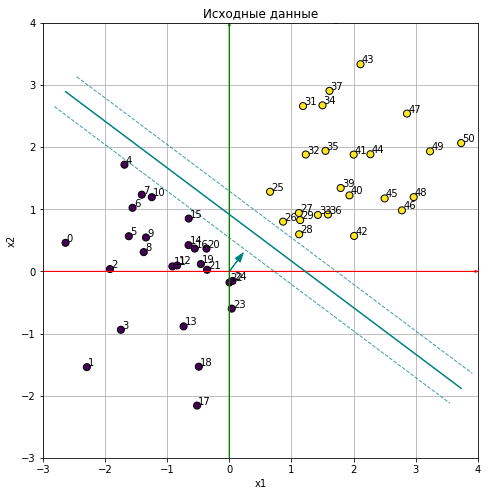

In [3]:
# Нумерация объектов
OBJECTS_NUMBERING = True

# Кооррдинаты разделяющей гиперплоскости (сплошная линия)
hp = pd.DataFrame({
    'x0': [X.x0.min(), X.x0.max()],
    'x1': [X.x1.min(), X.x1.max()]})
hp['x2'] = (-hp.x1 * W[1] - hp.x0 * W[0]) / W[2]

# Координаты границ области, свободной от объектов (пунктирные линии)
ba = hp - LIN_SEP_CLEAR_DIST * W / np.linalg.norm(W[1:])
bb = hp + LIN_SEP_CLEAR_DIST * W / np.linalg.norm(W[1:])

# Невообразимая красота
_, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X.x1, X.x2, c=y, s=50, edgecolor='black')
ax.plot(ba.x1, ba.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
ax.plot(bb.x1, bb.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
ax.plot(hp.x1, hp.x2, linestyle='-', color='teal')
ax.arrow(0, 0, W[1], W[2], length_includes_head=True, head_width=0.1, color='teal')
if OBJECTS_NUMBERING:
  for i, r in X.iterrows():
    ax.annotate(i, (r.x1 + 0.02, r.x2 + 0.02))
ax.set_title('Исходные данные')
get_shiny_square_axes(axes=ax, xlim=(-3, 4), ylim=(-3, 4), hw=0.03);

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

svm_m = MyShinySVM(eta0=0.01, alpha=0.1, epochs=50, verbose=True)
svm_m.fit(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())

# Матрица признаков уже содержит фиктивный признак
svm_y_pred = svm_m.predict(X)

# Точность и коэффициенты
svm_w = np.hstack((svm_m.intercept_, svm_m.coef_.flatten()))
print(f'\nТочность на обучающей выборке:\n {accuracy_score(y, svm_y_pred):.2%}\n')
print(f'Коэффиценты обученной модели SVM:\n {svm_w}')

Эпоха: 0        Свободный член: -0.02     Коэффициенты: [0.494  0.1741]   Soft margin loss on train data: 23.1678   Soft margin loss on validation data: 2.4551
Эпоха: 1        Свободный член: -0.12     Коэффициенты: [0.7193 0.1715]   Soft margin loss on train data: 9.9910   Soft margin loss on validation data: 1.5191
Эпоха: 2        Свободный член: -0.1798   Коэффициенты: [0.8243 0.2047]   Soft margin loss on train data: 6.4915   Soft margin loss on validation data: 1.0118
Эпоха: 3        Свободный член: -0.2197   Коэффициенты: [0.912  0.2344]   Soft margin loss on train data: 5.0145   Soft margin loss on validation data: 0.8292
Эпоха: 4        Свободный член: -0.2695   Коэффициенты: [0.9678 0.2472]   Soft margin loss on train data: 4.2448   Soft margin loss on validation data: 0.7424
Эпоха: 5        Свободный член: -0.3193   Коэффициенты: [1.0235 0.2601]   Soft margin loss on train data: 3.6637   Soft margin loss on validation data: 0.6935
Эпоха: 6        Свободный член: -0.369    Коэ

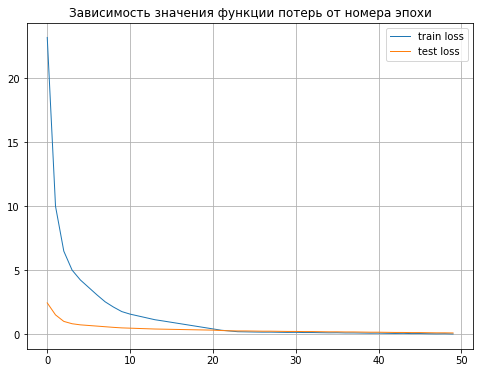

In [5]:
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(svm_m.train_loss_epoch_history, lw=1, label='train loss')
ax.plot(svm_m.val_loss_epoch_history, lw=1, label='test loss')
ax.grid()
ax.legend()
ax.set_title('Зависимость значения функции потерь от номера эпохи');

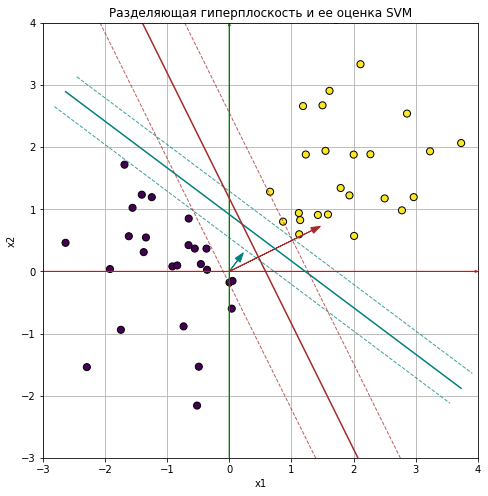

In [6]:
# Кооррдинаты разделяющей гиперплоскости реализованной модели SVM
svm_hp = pd.DataFrame({
    'x0': [X.x0.min(), X.x0.max()],
    'x1': [X.x1.min(), X.x1.max()]})
svm_hp['x2'] = (-svm_hp.x1 * svm_w[1] - svm_hp.x0 * svm_w[0]) / svm_w[2]

# Линии (множества точек) опорных векторов
# w2 * x2 + w1 * x1 + w0 = 1
svm_ba = svm_hp.copy()
svm_ba['x2'] = svm_ba['x2'] + 1 / svm_w[2]

# w2 * x2 + w1 * x1 + w0 = -1
svm_bb = svm_hp.copy()
svm_bb['x2'] = svm_bb['x2'] - 1 / svm_w[2]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X.x1, X.x2, c=y, s=50, edgecolor='black')
ax.plot(ba.x1, ba.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
ax.plot(bb.x1, bb.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
ax.plot(hp.x1, hp.x2, linestyle='-', color='teal')
ax.plot(svm_ba.x1, svm_ba.x2, linestyle='--', lw=1, color='brown', alpha=0.75)
ax.plot(svm_bb.x1, svm_bb.x2, linestyle='--', lw=1, color='brown', alpha=0.75)
ax.plot(svm_hp.x1, svm_hp.x2, linestyle='-', color='brown')
ax.arrow(0, 0, W[1], W[2], length_includes_head=True, head_width=0.1, color='teal')
ax.arrow(0, 0, svm_w[1], svm_w[2], length_includes_head=True, head_width=0.1, linestyle='-', color='brown')
ax.set_title('Разделяющая гиперплоскость и ее оценка SVM')
get_shiny_square_axes(axes=ax, xlim=(-3, 4), ylim=(-3, 4), hw=0.03);

In [7]:
FRAMES_STEP = 20

def render_frame(i):

  # Чтобы избежать деления на 0
  w = svm_m.w_step_history[i].copy()
  if w[2] == 0:
    w[2] += 1e-6

  svm_hp = pd.DataFrame({
      'x0': [X.x0.min(), X.x0.max()],
      'x1': [X.x1.min(), X.x1.max()]})
  svm_hp['x2'] = (-svm_hp.x1 * w[1] - svm_hp.x0 * w[0]) / w[2]

  svm_ba = svm_hp.copy()
  svm_ba['x2'] = svm_ba['x2'] + 1 / w[2]

  svm_bb = svm_hp.copy()
  svm_bb['x2'] = svm_bb['x2'] - 1 / w[2]

  ax.clear()
  ax.scatter(X.x1, X.x2, c=y, s=50, edgecolor='black')
  ax.plot(ba.x1, ba.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
  ax.plot(bb.x1, bb.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
  ax.plot(hp.x1, hp.x2, linestyle='-', color='teal')
  plot_line_svm_ba, = ax.plot(svm_ba.x1, svm_ba.x2, linestyle='--', lw=1, color='brown', alpha=0.75)
  plot_line_svm_bb, = ax.plot(svm_bb.x1, svm_bb.x2, linestyle='--', lw=1, color='brown', alpha=0.75)
  plot_line_svm_hp, = ax.plot(svm_hp.x1, svm_hp.x2, linestyle='-', color='brown')
  ax.arrow(0, 0, W[1], W[2], length_includes_head=True, head_width=0.1, color='teal')
  arrow_svm_w = ax.arrow(0, 0, w[1], w[2], length_includes_head=True, head_width=0.1, linestyle='-', color='brown')
  title_txt = ax.set_title(f'Обучение алгоритма SVM. Итерация = {i}, Шаг = {FRAMES_STEP}')
  fig.tight_layout()
  get_shiny_square_axes(axes=ax, xlim=(-3, 4), ylim=(-3, 4), hw=0.03);

  return (plot_line_svm_ba, plot_line_svm_bb, plot_line_svm_hp, arrow_svm_w)

frames_indices = list(range(0, len(svm_m.w_step_history), FRAMES_STEP))

anim  = animation.FuncAnimation(fig, render_frame, frames=frames_indices, interval=50, blit=True, repeat_delay=1000)
video = anim.to_html5_video()
display.HTML(video)

## Вывод